# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «XXX». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler,
    RobustScaler
)

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
BUDGET = 10_000_000_000
RESEARCH_POINTS = 500
BEST_POINTS = 200
SINGLE_PRODUCT = 450_000
BOOTSTRAP_SAMPLES = 1000

In [3]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')

In [4]:
geo_data_0.head(5)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
geo_data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [7]:
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')

In [8]:
geo_data_1.head(5)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [9]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [10]:
geo_data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [11]:
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [12]:
geo_data_2.head(5)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [13]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [14]:
geo_data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [15]:
geo_data_0.set_index('id', inplace=True)
geo_data_1.set_index('id', inplace=True)
geo_data_2.set_index('id', inplace=True)

In [16]:
display("0", geo_data_0.isna().sum())
display("1", geo_data_1.isna().sum())
display("2", geo_data_2.isna().sum())

'0'

f0         0
f1         0
f2         0
product    0
dtype: int64

'1'

f0         0
f1         0
f2         0
product    0
dtype: int64

'2'

f0         0
f1         0
f2         0
product    0
dtype: int64

In [17]:
display("0", geo_data_0.duplicated().sum())
display("1", geo_data_1.duplicated().sum())
display("2", geo_data_2.duplicated().sum())

'0'

0

'1'

0

'2'

0

In [18]:
display("0", geo_data_0.nunique())
display("1", geo_data_1.nunique())
display("2", geo_data_2.nunique())

'0'

f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

'1'

f0         100000
f1         100000
f2         100000
product        12
dtype: int64

'2'

f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

In [19]:
geo_data_1['product'].unique()

array([  3.17910258,  26.95326103, 134.76630516, 137.94540774,
        84.03888568, 110.99214671,  53.90652206,   0.        ,
       107.81304413,  57.08562465,  30.13236361,  80.85978309])

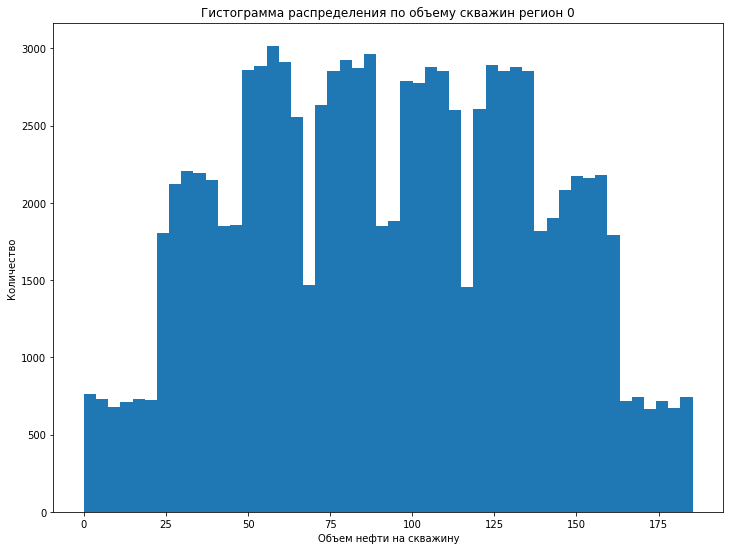

In [20]:
plt.figure(figsize=[12,9])

plt.hist(geo_data_0['product'], bins=50)

plt.xlabel("Объем нефти на скважину")
plt.ylabel("Количество")
plt.title("Гистограмма распределения по объему скважин регион 0")
plt.show()

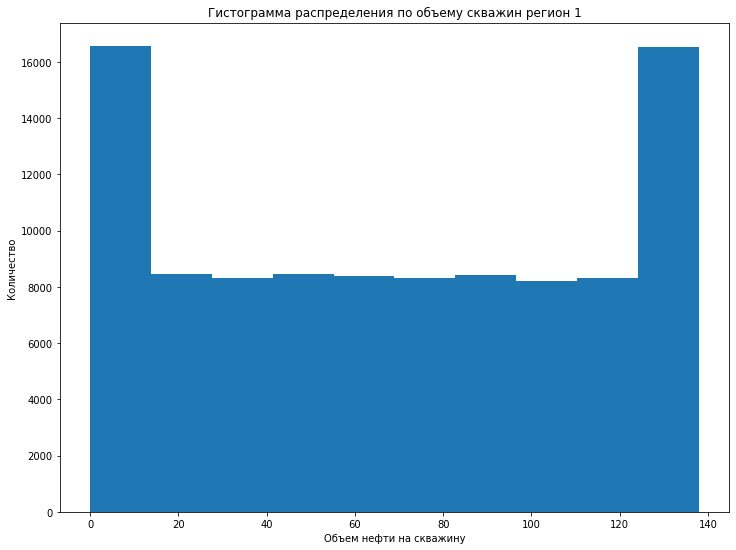

In [21]:
plt.figure(figsize=[12,9])

plt.hist(geo_data_1['product'], bins=10)

plt.xlabel("Объем нефти на скважину")
plt.ylabel("Количество")
plt.title("Гистограмма распределения по объему скважин регион 1")
plt.show()

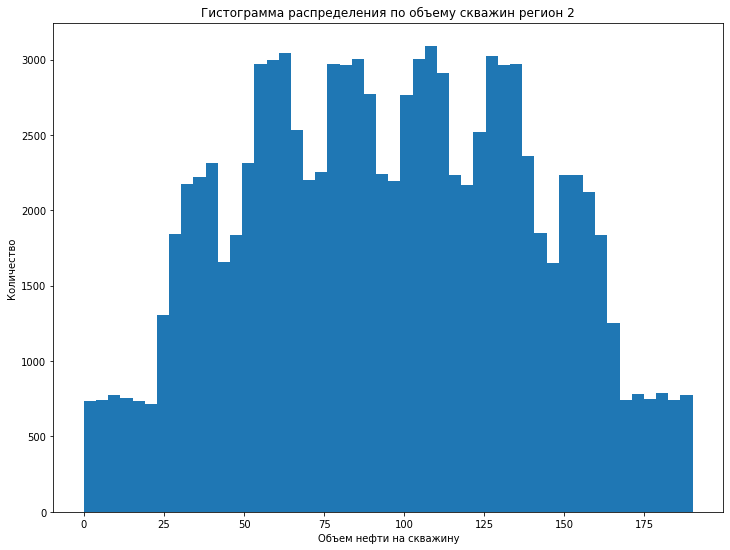

In [22]:
plt.figure(figsize=[12,9])

plt.hist(geo_data_2['product'], bins=50)

plt.xlabel("Объем нефти на скважину")
plt.ylabel("Количество")
plt.title("Гистограмма распределения по объему скважин регион 2")
plt.show()

**Вывод:**

    - Были выгружены данные 3х разных регионов(0,1,2). Здесь и далее регионы будут обозначаться цифрами 0, 1, 2 соответственно.
    - В каждом файле было по 100000 записей.
    - Дубликатов и пустых значений не найдено.
    - Тем не менее есть нулевые значения, но это вполне себе возможно, что скважина будет пустая - следновательно их исключать нельзя.
    - Также было обнаружено, что в регионе 1 всего 12 уникальных значений, тем не менее обогащать их нечем и не откуда, следовательно оставляем как есть.
    - Были рассмотрены гистограмы каждого региона у региона 1 распределены данные не нормально(по описанным выше причинам), а в остальных регионах близко к нормальному.

## Обучение и проверка модели

In [23]:
def prepare_data(data):
    X = data.drop(columns='product', axis=1)
    y = data['product']
    
    return train_test_split(
        X,
        y,
        test_size = TEST_SIZE,
        random_state = RANDOM_STATE
    )

In [24]:
data_preprocessor = ColumnTransformer([
     ('num', MinMaxScaler(), ['f0', 'f1', 'f2'])
    ], 
    remainder='passthrough'
)

pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [25]:
def train_test_model(pipe, data):
    X_train, X_valid, y_train, y_valid = prepare_data(data)
    pipe.fit(X_train, y_train)
    
    predict = pipe.predict(X_valid)
    
    saved = {
        'product' : y_valid,
        'predicted' : predict   
    }
    info = pd.DataFrame(saved, columns = ['product', 'predicted'])
    rmse = round(mean_squared_error(y_valid, predict)**0.5, 2)
    mean_info = round(info['predicted'].mean(), 2)

    print("mean:", mean_info)
    print("rmse:", rmse)
    
    return info, rmse, mean_info

In [26]:
info_0, rmse_0, mean_0 = train_test_model(pipe, geo_data_0)

mean: 92.4
rmse: 37.76


In [27]:
info_1, rmse_1, mean_1 = train_test_model(pipe, geo_data_1)

mean: 68.71
rmse: 0.89


In [28]:
info_2, rmse_2, mean_2 = train_test_model(pipe, geo_data_2)

mean: 94.77
rmse: 40.15


**Выводы:**

    - LinearRegression показала лучше всего себя и лучше всего на данных 1 региона.
    - В среднем предсказано барелей: 0 - 92.4, 1 - 68.71, 2 - 94.77. Наибольшее среднее у 2го региона.
    - RMSE по регионам: 0 - 37.76, 1 - 0.89, 2 - 40.15. Лучший у 1 региона.
    - Из-за того, что в регионе 1 данные имели всего 12 уникальных значений, мы не можем доверять обученной модели.
    - Даже если принимать во внимание качество модели и считать модель 1го региону лучшей, там мы получим в среднем меньше всего бареллей.

## Подготовка к расчёту прибыли

In [29]:
profit_point = BUDGET / BEST_POINTS
print('Прибыль на лучшую точку:', profit_point)

Прибыль на лучшую точку: 50000000.0


In [30]:
barrel_point = round(profit_point / SINGLE_PRODUCT, 2)
print('Объем лучшей точки:', barrel_point)

Объем лучшей точки: 111.11


In [31]:
print('Средний запас фактичекой нефти на скважину в регионе 0:', round(info_0['product'].mean(), 2))
print('Средний запас фактичекой нефти на скважину в регионе 1:', round(info_1['product'].mean(), 2))
print('Средний запас фактичекой нефти на скважину в регионе 2:', round(info_2['product'].mean(), 2))

Средний запас фактичекой нефти на скважину в регионе 0: 92.33
Средний запас фактичекой нефти на скважину в регионе 1: 68.73
Средний запас фактичекой нефти на скважину в регионе 2: 95.15


In [32]:
def profit(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count].sum()
    
    return SINGLE_PRODUCT * selected - BUDGET

**Вывод:**

    - Прибыль лучшей точки должна составить 50000000 руб.
    - Средний объем лучшей точки должен быть равен 111.11.
    - Средний объем каждой точки в регионах равна 0 - 92.33, 1 - 68.73, 2 - 95.15. Каждый регион в среднем меньше, чем требуется, следовательно придется отбирать лучшие точки.

## Расчёт прибыли и рисков 

In [33]:
state = np.random.RandomState(12345)

In [34]:
def bootstrap_research(data):
    values = []
    for i in range(BOOTSTRAP_SAMPLES):
        target_sub = data['product'].sample(n=RESEARCH_POINTS, replace=True, random_state=state)
        prob_sub = data['predicted'][target_sub.index]
        
        values.append(profit(target_sub, prob_sub, BEST_POINTS))

    values = pd.Series(values)
    print("Средняя выручка:", round(values.mean(), 2))
    print("95% интервал: от", round(values.quantile(0.025), 2), "до", round(values.quantile(0.975), 2))
    print("Риск убытков", round((values < 0).mean()*100, 2), "%")

In [35]:
bootstrap_research(info_0)

Средняя выручка: 435933772.14
95% интервал: от -116231612.78 до 966504180.71
Риск убытков 6.1 %


In [36]:
bootstrap_research(info_1)

Средняя выручка: 498569016.92
95% интервал: от 75315573.09 до 911503695.02
Риск убытков 1.0 %


In [37]:
bootstrap_research(info_2)

Средняя выручка: 412672898.99
95% интервал: от -158939515.76 до 978191201.7
Риск убытков 7.0 %


**Вывод:**

    - По региону 0 имеем - среднюю выручку 435933772.14 на интервале от -116231612.78 до 966504180.71, с риском убытков 6.1%.
    - По региону 1 имеем - среднюю выручку 498569016.92 на интервале от 75315573.09 до 911503695.02, с риском убытков 1%.
    - По региону 2 имеем - среднюю выручку 412672898.99 на интервале от -158939515.76 до 978191201.7, с риском убытков 7%.
    - По всем текущим выборкам и анализу наиболее подходящий регион 1. Он имеет лучшую среднюю выручку на приятном доверительном интервале и минимальный риск 1%(что удовлетворяет условию задачи).
    - Тем не менее, учитывая, что данные в регионе 1 были некорректны(так как имеем только 12 уникальных значений product), то подходящего региона не найдено. Так как остальные регионы имеют риск убытков больше 2.5%.

## Общий вывод

**Описание задачи:**

    - Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.
    

**Загрузка и подготовка данных:**

    - Были выгружены данные 3х разных регионов(0,1,2). Здесь и далее регионы будут обозначаться цифрами 0, 1, 2 соответственно.
    - В каждом файле было по 100000 записей.
    - Дубликатов и пустых значений не найдено.
    - Тем не менее есть нулевые значения, но это вполне себе возможно, что скважина будет пустая - следновательно их исключать нельзя.
    - Также было обнаружено, что в регионе 1 всего 12 уникальных значений, тем не менее обогащать их нечем и не откуда, следовательно оставляем как есть.
    - Были рассмотрены гистограмы каждого региона у региона 1 распределены данные не нормально(по описанным выше причинам), а в остальных регионах близко к нормальному.
    
**Обучение и проверка модели:**

    - LinearRegression показала лучше всего себя и лучше всего на данных 1 региона.
    - В среднем предсказано барелей: 0 - 92.4, 1 - 68.71, 2 - 94.77. Наибольшее среднее у 2го региона.
    - RMSE по регионам: 0 - 37.76, 1 - 0.89, 2 - 40.15. Лучший у 1 региона.
    - Из-за того, что в регионе 1 данные имели всего 12 уникальных значений, мы не можем доверять обученной модели.
    - Даже если принимать во внимание качество модели и считать модель 1го региону лучшей, там мы получим в среднем меньше всего бареллей.
    
**Подготовка к расчету прибыли:**

    - Прибыль лучшей точки должна составить 50000000 руб.
    - Средний объем лучшей точки должен быть равен 111.11.
    - Средний объем каждой точки в регионах равна 0 - 92.33, 1 - 68.73, 2 - 95.15. Каждый регион в среднем меньше, чем требуется, следовательно придется отбирать лучшие точки.
    
**Расчет прибыли и рисков:**

    - По региону 0 имеем - среднюю выручку 435933772.14 на интервале от -116231612.78 до 966504180.71, с риском убытков 6.1%.
    - По региону 1 имеем - среднюю выручку 498569016.92 на интервале от 75315573.09 до 911503695.02, с риском убытков 1%.
    - По региону 2 имеем - среднюю выручку 412672898.99 на интервале от -158939515.76 до 978191201.7, с риском убытков 7%.
    - По всем текущим выборкам и анализу наиболее подходящий регион 1. Он имеет лучшую среднюю выручку на приятном доверительном интервале и минимальный риск 1%(что удовлетворяет условию задачи).
    - Тем не менее, учитывая, что данные в регионе 1 были некорректны(так как имеем только 12 уникальных значений product), то подходящего региона не найдено. Так как остальные регионы имеют риск убытков больше 2.5%.